In [111]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn import metrics
import time

#GridSearchCV
from sklearn.model_selection import GridSearchCV

#SVM
from sklearn import svm

#XGB
import xgboost as xgb

#RandomForest
from sklearn.ensemble import RandomForestClassifier

#VotingClassifier
from sklearn.ensemble import VotingClassifier

In [112]:
# manual parameters
TEST_RATIO = 0.2
RANDOM_SEED = 42

In [113]:
train = pd.read_csv("/home/vijay/Desktop/Major_Project/Datasets/train_LZdllcl.csv")
test = pd.read_csv("/home/vijay/Desktop/Major_Project/Datasets/test_2umaH9m.csv")

In [114]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [115]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [116]:
train.previous_year_rating.value_counts(dropna=False)

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
NaN     4124
Name: previous_year_rating, dtype: int64

In [117]:
train = train.dropna()

In [118]:
train = train.drop(['region', 'gender', 'age', 'recruitment_channel','employee_id'], axis=1)

In [119]:
#once again checking for null values 
train.isnull().sum()

department              0
education               0
no_of_trainings         0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [120]:
#resetting index values 
train = train.reset_index(drop = True)

In [121]:
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [122]:
test.previous_year_rating.value_counts(dropna=False)

3.0    7921
5.0    5097
4.0    4249
1.0    2680
NaN    1812
2.0    1731
Name: previous_year_rating, dtype: int64

In [123]:
test = test.dropna()

In [124]:
test = test.drop(['region', 'gender', 'age', 'recruitment_channel'], axis=1)

In [125]:
test = test.reset_index(drop = True)

In [126]:
labels = train.is_promoted.values.tolist()
labels1 = train.department.values.tolist()
df = pd.DataFrame(list(zip(labels1, labels)),
               columns =['DEPT', 'PROM'])
df

,DEPT,PROM
0,Sales & Marketing,0
1,Operations,0
2,Sales & Marketing,0
3,Sales & Marketing,0
4,Technology,0
...,...,...
48655,Sales & Marketing,0
48656,Technology,0
48657,Operations,0
48658,Analytics,0


In [127]:
dept_emp_num =  df.groupby('DEPT')['DEPT'].count().sort_values(ascending=False)
print(dept_emp_num)

DEPT
Sales & Marketing    14239
Operations           10547
Procurement           6641
Technology            6502
Analytics             4610
Finance               2219
HR                    2142
R&D                    893
Legal                  867
Name: DEPT, dtype: int64


In [128]:
df_filtered = df[df['PROM'] == 1]
dept_emp_num1 =  df_filtered.groupby('DEPT')['DEPT'].count().sort_values(ascending=False)
print(dept_emp_num1)

DEPT
Sales & Marketing    1060
Operations            979
Technology            694
Procurement           651
Analytics             445
Finance               182
HR                    121
R&D                    58
Legal                  42
Name: DEPT, dtype: int64


In [129]:
def create_stacked_bar(column_name):

    promo_by_group = pd.crosstab(index=train['is_promoted'],columns = train[column_name], normalize = 'columns')
    promo_by_group = promo_by_group.apply(lambda x: round(x,2))
    
    labels = promo_by_group.columns
    list1 = promo_by_group.iloc[0].to_list()
    list2 = promo_by_group.iloc[1].to_list()
    
    list1_name = "Not promoted"
    list2_name = "Promoted"
    title = f"Promotion by {column_name}"
    xlabel = column_name
    ylabel = "Promotion percentage"
    
    fig, ax = plt.subplots(figsize=(15, 6))
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold")
    ax.set_xlabel(xlabel, fontweight = "bold")
    ax.set_ylabel(ylabel, fontweight = "bold")
    ax.legend(loc="best")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=9)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="white", fontsize=9, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="white", fontsize=9, fontweight="bold")

    plt.show()

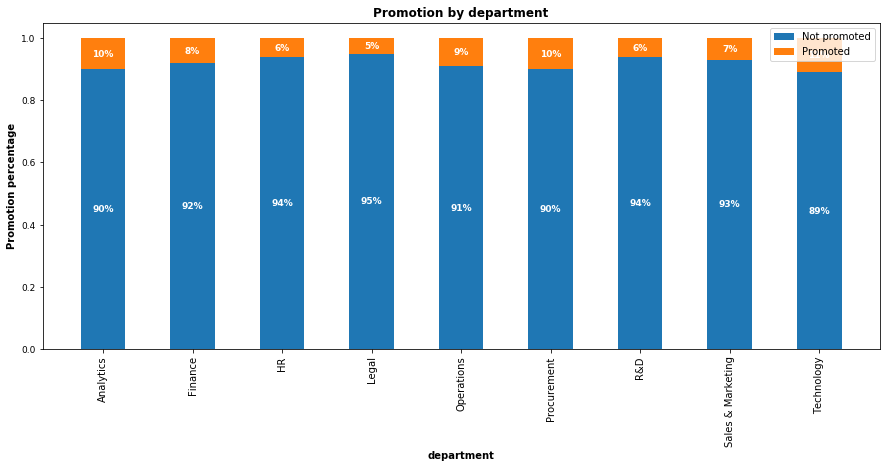

In [130]:
create_stacked_bar('department')

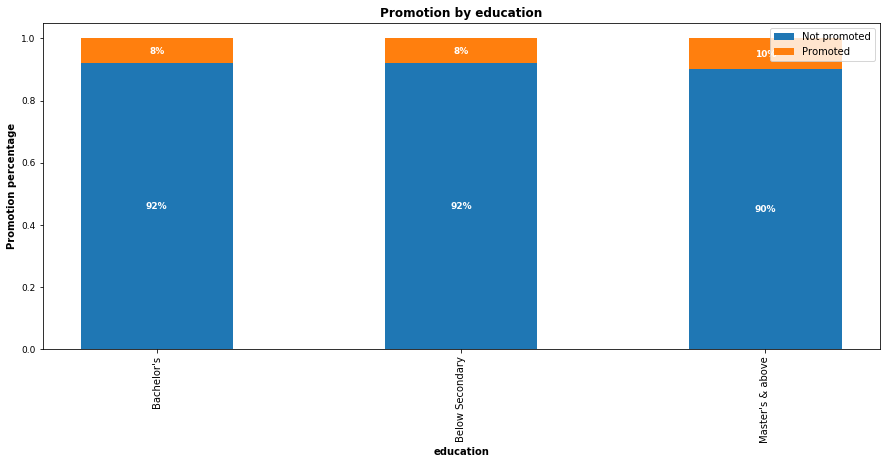

In [131]:
create_stacked_bar('education')

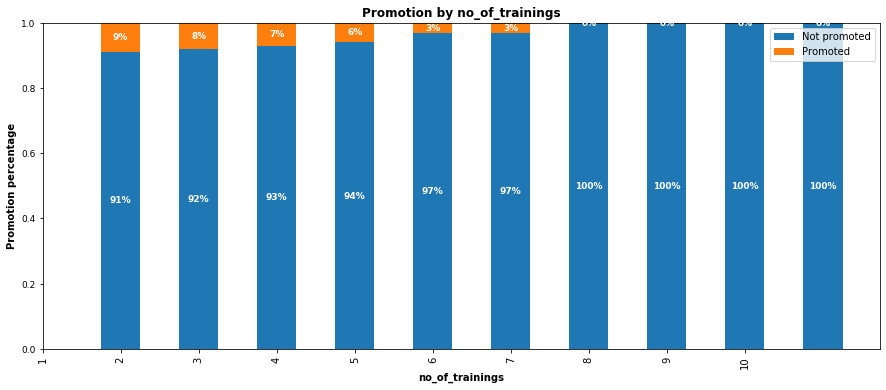

In [132]:
create_stacked_bar('no_of_trainings')

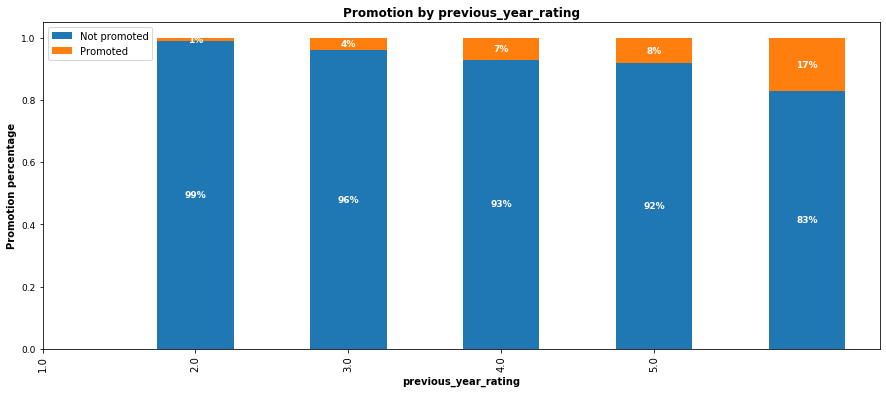

In [133]:
create_stacked_bar('previous_year_rating')

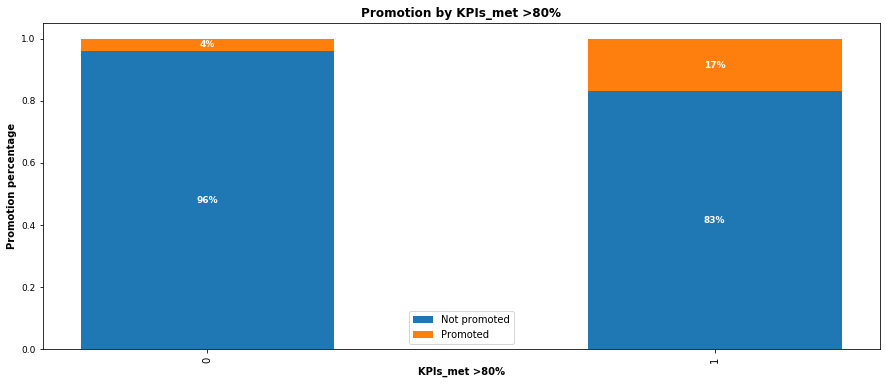

In [134]:
create_stacked_bar('KPIs_met >80%')

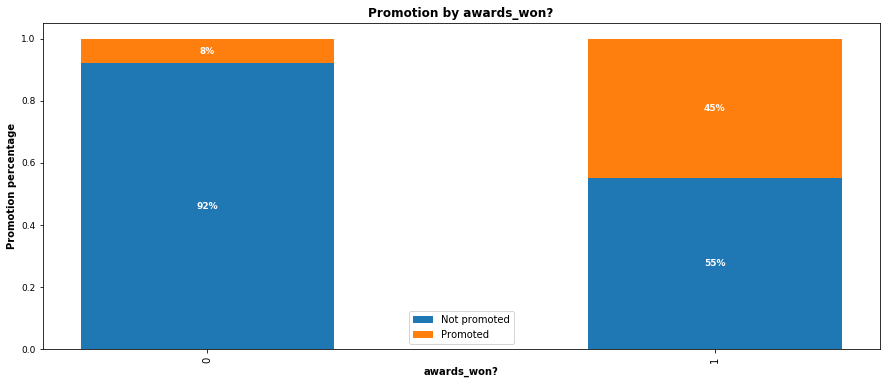

In [135]:
create_stacked_bar('awards_won?')

In [136]:
train['service_catg'] = pd.cut(
    train.length_of_service,
    bins=[0,2,7,10,37],
    labels=['New','Established','Experienced','Veteran']
)

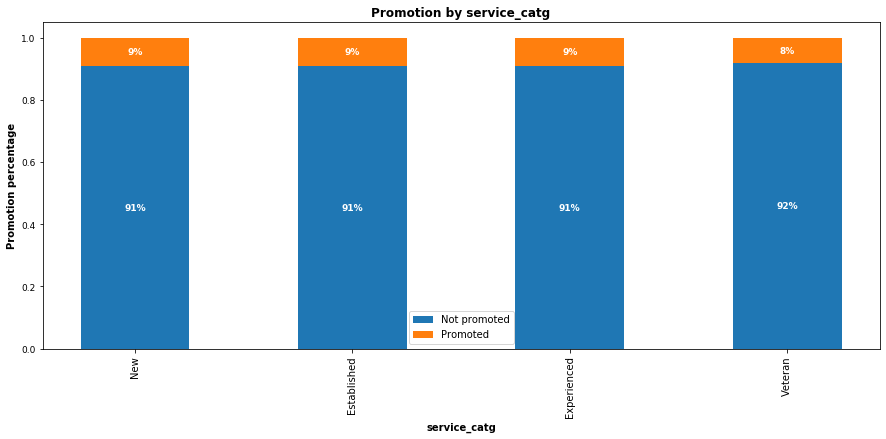

In [137]:
create_stacked_bar('service_catg')

In [138]:
train = train.drop(['service_catg'], axis=1)

In [139]:
#2.Data Cleaning
edu = {"Master's & above": 1, "Bachelor's": 2, "Below Secondary": 3}
data = [train,test]

for dataset in data:
    dataset['education'] = dataset['education'].map(edu)

In [140]:
dept = {"Sales & Marketing": 1, "Operations": 2, "Technology": 3, "Analytics": 4, "R&D": 5, "Procurement": 6, "Finance": 7, "HR": 8, "Legal": 9}
data = [train,test]

for dataset in data:
    dataset['department'] = dataset['department'].map(dept)

In [141]:
train.head()

,department,education,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,1,1,1,5.0,8,1,0,49,0
1,2,2,1,5.0,4,0,0,60,0
2,1,2,1,3.0,7,0,0,50,0
3,1,2,2,1.0,10,0,0,50,0
4,3,2,1,3.0,2,0,0,73,0


In [142]:
test.head()

,employee_id,department,education,no_of_trainings,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,74430,8,2,1,3.0,5,0,0,51
1,72255,1,2,1,1.0,4,0,0,47
2,38562,6,2,3,2.0,9,0,0,65
3,64486,7,2,1,4.0,7,0,0,61
4,46232,6,2,1,3.0,2,0,0,68


In [143]:
train = train.head(7000)

In [144]:
test = test.head(4500)

In [145]:
emp_id = test.employee_id

In [146]:
#Data Splitting-------------
features = train.drop('is_promoted', axis=1).values
labels = train.is_promoted.values

# splitting our 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=TEST_RATIO,
                                                    random_state=RANDOM_SEED)

In [147]:
def training_accuracy_report(GridSearchCv_classifier):
    print(
f"""Best parameters: 
    {GridSearchCv_classifier.best_params_}
    
Best estimator:
    {GridSearchCv_classifier.best_estimator_}
    
Mean cross-validated score of the best_estimator on the training set:
    {GridSearchCv_classifier.best_score_*100:,.2f}%    
""")

In [148]:
#Classification
#SVM----------------------------------
# parameter grid for our search

start_time=time.time()

parameters = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4], # only applies to kernel == 'poly'
    'kernel': ('linear', 'rbf', 'poly')
}

# initiating our support vector machine
svm = svm.SVC(gamma='scale',
              probability=True,
              random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=svm,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_svm = classifier.fit(X_train, y_train)

end_time=time.time()

print("Execution Time:%.2f" %(end_time-start_time))

time_svm = end_time-start_time

# view the results of our cross-validated grid search 
training_accuracy_report(best_svm)

Execution Time:486.85
Best parameters: 
    {'C': 10, 'degree': 4, 'kernel': 'poly'}
    
Best estimator:
    SVC(C=10, degree=4, kernel='poly', probability=True, random_state=42)
    
Mean cross-validated score of the best_estimator on the training set:
    91.25%    



In [149]:
# for accuracy calculation
from sklearn import metrics

# make predictions
y_pred_svm = best_svm.predict(X_test)
accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_svm*100:,.2f}%')

Accuracy on the test set: 92.50%


In [150]:
#XGB---------------------------------------
# parameter grid for our search

start_time=time.time()

parameters = {
    'min_child_weight': [5, 6, 7],
    'gamma': [0, 0.2],
    'colsample_bytree': [0, 0.2, 0.4],
    'max_depth': [3, 4, 5]
}

# initiating our gradient boosted tree
xgb = xgb.XGBClassifier(objective='reg:squarederror', random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=xgb,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_xgb = classifier.fit(X_train, y_train)

end_time=time.time()

print("Execution Time:%.2f" %(end_time-start_time))

time_xgb = end_time-start_time

# view the results of our cross-validated grid search 
training_accuracy_report(best_xgb)

Execution Time:29.04
Best parameters: 
    {'colsample_bytree': 0.4, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 7}
    
Best estimator:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
    
Mean cross-validated score of the best_estimator on the training set:
    93.54%    



In [79]:
# make predictions
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = metrics.accuracy_score(y_test, y_pred_xgb)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_xgb*100:,.2f}%')

Accuracy on the test set: 94.14%


In [151]:
#RandomForest---------------------------
# parameter grid for our search

start_time=time.time()

parameters = {
    'n_estimators': [75, 100, 125, ],
    'max_depth': [10, 50, 100, None],
    'max_features': [0.5, 1],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [2, 3]
}

rfc = RandomForestClassifier(criterion='gini',
                             bootstrap=False,
                             random_state=RANDOM_SEED)
classifier = GridSearchCV(estimator=rfc,
                          param_grid=parameters,
                          cv=5)

# fitting the model
best_rfc = classifier.fit(X_train, y_train)

end_time=time.time()

print("Execution Time:%.2f" %(end_time-start_time))

time_rfc = end_time-start_time

# view the results of our cross-validated grid search 
training_accuracy_report(best_rfc)


Execution Time:332.28
Best parameters: 
    {'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 75}
    
Best estimator:
    RandomForestClassifier(bootstrap=False, max_depth=50, max_features=0.5,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=75, random_state=42)
    
Mean cross-validated score of the best_estimator on the training set:
    92.96%    



In [152]:
# make predictions
y_pred_rfc = best_rfc.predict(X_test)
accuracy_rfc = metrics.accuracy_score(y_test, y_pred_rfc)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_rfc*100:,.2f}%')

Accuracy on the test set: 92.79%


In [153]:
# configuring 
#VotingClassifier---------------------------

start_time=time.time()

vc = VotingClassifier(
    
    # all classifiers we just gridsearched
    estimators=[
        ('svm', best_svm),
        ('xgb', best_xgb),
        ('rfc', best_rfc)
    ], 
    
    # soft = probabilities are taken into account
    # hard = only the outcome counts
    voting='soft',
    
    # you can add weights, as well. E.g.
    weights=[1,4,1]
    
)

# fitting
vc = vc.fit(X_train, y_train)

end_time=time.time()

print("Execution Time:%.2f" %(end_time-start_time))

time_vc = end_time-start_time

Execution Time:851.71


In [154]:
# accuracy on test set
y_pred_vc = vc.predict(X_test)
accuracy_vc = metrics.accuracy_score(y_test, y_pred_vc)

# how often is the classifier correct?
print(f'Accuracy on the test set: {accuracy_vc*100:,.2f}%')

Accuracy on the test set: 94.07%


In [155]:
test = test.drop(['employee_id'], axis=1)

In [156]:
pred = best_xgb.predict(test.values)

In [157]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [158]:
Promotion = pd.Series(pred, name="is_promoted")

In [159]:
submission = pd.concat([emp_id, Promotion], axis=1)

In [160]:
submission.to_csv(r'/home/vijay/Desktop/Major_Project/Datasets/Output.csv', index=False)

In [161]:
feature_importances = best_xgb.best_estimator_.feature_importances_

In [162]:
feature_importances

array([0.18824868, 0.03414061, 0.02797543, 0.07918282, 0.03094321,
       0.24915205, 0.15024072, 0.24011648], dtype=float32)

In [163]:
feature_names = test.columns.tolist()

In [164]:
feature_imp = feature_importances.tolist() 

In [165]:
df = pd.DataFrame(list(zip(feature_names, feature_imp)),
               columns =['FEATURE_NAMES', 'FEATURE_IMPORTANCE'])

In [166]:
df

,FEATURE_NAMES,FEATURE_IMPORTANCE
0,department,0.188249
1,education,0.034141
2,no_of_trainings,0.027975
3,previous_year_rating,0.079183
4,length_of_service,0.030943
5,KPIs_met >80%,0.249152
6,awards_won?,0.150241
7,avg_training_score,0.240116


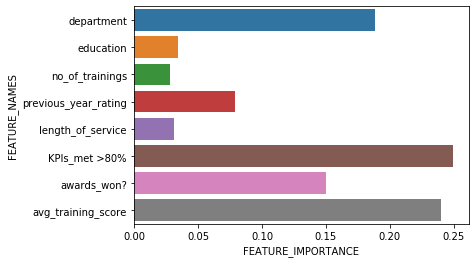

In [167]:
sns.barplot(x='FEATURE_IMPORTANCE', y='FEATURE_NAMES', data=df)

In [168]:
#accuracy of each models 
acc_svm = round(accuracy_svm*100, 2)
acc_xgb = round(accuracy_xgb*100, 2)
acc_rfc = round(accuracy_rfc*100, 2)
acc_vc = round(accuracy_vc*100, 2)

In [169]:
#mean_squared_error
mae_svm = round(metrics.mean_absolute_error(y_test, best_svm.predict(X_test))*100, 2)
mae_xgb = round(metrics.mean_absolute_error(y_test, best_xgb.predict(X_test))*100, 2)
mae_rfc = round(metrics.mean_absolute_error(y_test, best_rfc.predict(X_test))*100, 2)
mae_vc = round(metrics.mean_absolute_error(y_test, vc.predict(X_test))*100, 2)


In [170]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'XGBoost', 'Random Forest Classifier', 'Voting Classifier'],
    'Score': [acc_svm, acc_xgb, acc_rfc, acc_vc],
    'MAE': [mae_svm,mae_xgb,mae_rfc,mae_vc]})
            
result_df = results.sort_values(by='Score', ascending=False)
result_df

,Model,Score,MAE
1,XGBoost,94.14,5.86
3,Voting Classifier,94.07,5.93
2,Random Forest Classifier,92.79,7.21
0,Support Vector Machines,92.50,7.50


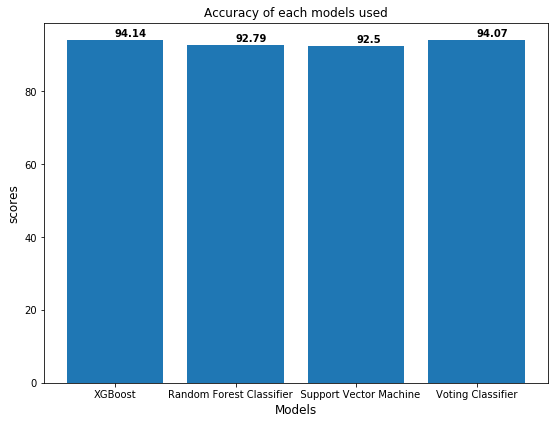

In [171]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
models = ['XGBoost', 'Random Forest Classifier   ', '   Support Vector Machine', 'Voting Classifier']
scores = [acc_xgb,acc_rfc,acc_svm,acc_vc]
ax.bar(models,scores)
ax.set_ylabel('scores',fontsize= 12)
ax.set_xlabel('Models',fontsize= 12)
ax.set_title('Accuracy of each models used')
for i, v in enumerate(scores):
    ax.text( i ,v + 1, str(v), color='black', fontweight='bold')
    plt.savefig('barplot_1.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

In [172]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'XGBoost', 'Random Forest Classifier', 'Voting Classifier'],
    'Execution Time': [round(time_svm, 2), round(time_xgb, 2), round(time_rfc, 2), round(time_vc, 2)]})
            
result_df = results.sort_values(by='Execution Time', ascending=False)
result_df

,Model,Execution Time
3,Voting Classifier,851.71
0,Support Vector Machines,486.85
2,Random Forest Classifier,332.28
1,XGBoost,29.04


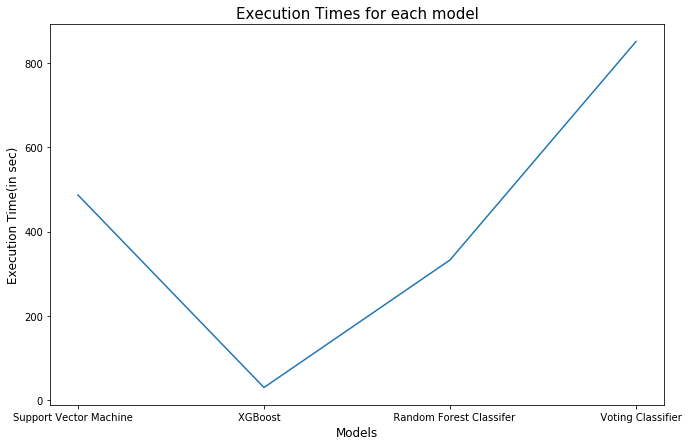

In [173]:
fig = plt.figure(figsize=(11,7))
models = ['Support Vector Machine   ', 'XGBoost   ', 
          '   Random Forest Classifer', '   Voting Classifier']
executionTime=[round(time_svm, 2), round(time_xgb, 2), round(time_rfc, 2), round(time_vc, 2)]
plt.plot(models,executionTime)
plt.xlabel('Models',fontsize=12)
plt.ylabel('Execution Time(in sec)',fontsize=12)
plt.title('Execution Times for each model',fontsize=15)
plt.show()